<a href="https://colab.research.google.com/github/melinadwisafitri/skripsi_price_predict/blob/main/cabai_merah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [ ]:
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import math

from keras.utils.vis_utils import plot_model
from tensorflow.data import Dataset
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

## time step generator

In [ ]:
def time_step_generator(data, time_size, batch_size, shuffle_data):
  dataset = Dataset.from_tensor_slices(data)
  dataset = dataset.window(time_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(time_size+1))
  dataset = dataset.shuffle(shuffle_data)
  dataset = dataset.map(lambda x: (x[:-1], x[-1]))
  return dataset.batch(batch_size).prefetch(1)

def forecast_predict(model, data, time_size, batch_size):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_step = generate_data.window(time_size, shift=1, drop_remainder=True)
  flatten_window = add_window_step.flat_map(lambda window: window.batch(time_size))
  batch_window = flatten_window.batch(batch_size).prefetch(1)
  model_predict = model.predict(batch_window)
  return model_predict

## Load data

In [ ]:
url ='https://github.com/melinadwisafitri/skripsi_price_predict/blob/main/data_pangan/data_fixs/data_new.csv?raw=true'
urllib.request.urlretrieve(url, 'data_pangan.csv')

('data_pangan.csv', <http.client.HTTPMessage at 0x7f183067dd90>)

In [ ]:
dataset = pd.read_csv('data_pangan.csv')
dataset.head()

,date,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam_ras_segar,daging_sapi_kualitas_1,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
0,2017-01-08,11200,10150,9650,11250,11150,12750,12250,34100,118400,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
1,2017-01-11,11400,10350,9900,11500,11300,12900,12350,30350,117000,...,30000,30000,30450,13900,12250,14950,14300,14500,16550,12900
2,2017-01-12,10700,9650,8500,11200,10950,12250,11850,29350,115800,...,33300,31500,35050,14000,12150,15400,14400,14800,16650,12950
3,2017-02-08,11200,10150,9650,11250,11150,12750,12250,34150,118400,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
4,2017-02-10,11400,10250,9850,11400,11250,12850,12350,30200,118400,...,31850,32550,31550,14000,12350,15000,14350,14700,16750,12950


In [ ]:
dataset['date'] = pd.to_datetime(dataset['date'])

In [ ]:
dataset = dataset.set_index('date')
dataset = dataset.sort_index()
train = dataset.cabai_merah.values
date = dataset.index

## Train test val split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train, date, test_size=0.2, random_state=False, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=False, shuffle=False) # 0.125 x 0.48 = 0.1

print(f'{len(x_train)}\n{len(x_test)}')

818
234


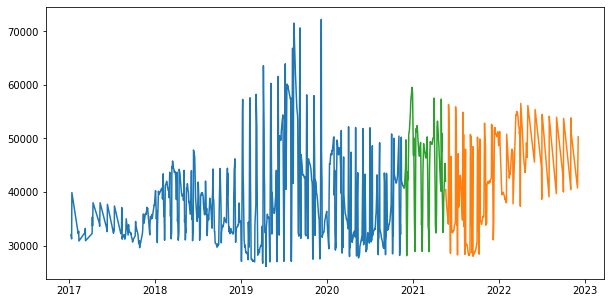

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_train, x_train)
plt.plot(y_test, x_test)
plt.plot(y_val, x_val)
plt.show()

## data generate

In [ ]:
scal_range= MinMaxScaler(feature_range=(0,1))
train_scal = scal_range.fit_transform(x_train.reshape(-1, 1))
test_scal = scal_range.fit_transform(x_test.reshape(-1, 1))
val_scal = scal_range.fit_transform(x_val.reshape(-1, 1))
train_step = time_step_generator(train_scal, time_size=600, shuffle_data=100, batch_size=5)
val_step = time_step_generator(val_scal, time_size=80, shuffle_data=100, batch_size=20)
test_step = time_step_generator(test_scal, time_size=150, shuffle_data=1000, batch_size=5)

train_step1 = time_step_generator(train_scal, time_size=100, shuffle_data=100, batch_size=1)
val_step1 = time_step_generator(val_scal, time_size=1, shuffle_data=10, batch_size=1)
test_step1 = time_step_generator(test_scal, time_size=10, shuffle_data=100, batch_size=1)

train_step2 = time_step_generator(train_scal, time_size=400, shuffle_data=1000, batch_size=5)
val_step2 = time_step_generator(val_scal, time_size=50, shuffle_data=100, batch_size=2)
test_step2 = time_step_generator(test_scal, time_size=100, shuffle_data=1000, batch_size=5)

In [ ]:
forecast = np.append(x_train, x_test)
forecast_date = np.append(y_train, y_test)
win_size= 400
win_size1 = 60
win_size2=150
test_cabaimerah_ = scal_range.fit_transform(forecast.reshape(-1, 1))

## model 

### SGD

In [ ]:
model= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
    LSTM(24, return_sequences=True),
    LSTM(20),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          48        
                                                                 
 lstm (LSTM)                 (None, None, 24)          3936      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3600      
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# plot_model(model, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

#### type1

In [ ]:
history = model.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 24s 353ms/step - loss: 0.0792 - mae: 0.2352 - mape: 91.5935 - val_loss: 0.3024 - val_mae: 0.5032 - val_mape: 92.4673
Epoch 2/30
44/44 [==============================] - 9s 194ms/step - loss: 0.0608 - mae: 0.1947 - mape: 67.2391 - val_loss: 0.2630 - val_mae: 0.4623 - val_mape: 82.3038
Epoch 3/30
44/44 [==============================] - 9s 193ms/step - loss: 0.0486 - mae: 0.1660 - mape: 56.2963 - val_loss: 0.2342 - val_mae: 0.4300 - val_mape: 74.2904
Epoch 4/30
44/44 [==============================] - 9s 197ms/step - loss: 0.0401 - mae: 0.1484 - mape: 54.2129 - val_loss: 0.2112 - val_mae: 0.4024 - val_mape: 67.4334
Epoch 5/30
44/44 [==============================] - 9s 195ms/step - loss: 0.0341 - mae: 0.1381 - mape: 57.3607 - val_loss: 0.1932 - val_mae: 0.3813 - val_mape: 63.1359
Epoch 6/30
44/44 [==============================] - 9s 194ms/step - loss: 0.0301 - mae: 0.1343 - mape: 62.6879 - val_loss: 0.1794 - val_mae: 0.3649 - val_mape:

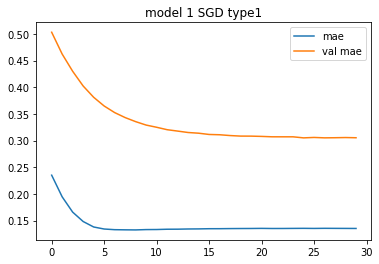

In [ ]:
mae = history.history['mae']
val_mae = history.history['val_mae']
epoch = range(len(mae))

plt.title('model 1 SGD type1')
plt.plot(epoch, mae, label='mae')
plt.plot(epoch, val_mae, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 4s 23ms/step
7523.8447 17.46363 9087.604744925915


,date,actual,prediction
0,2021-05-20,40450,37632.074219
1,2021-05-21,39500,37665.542969
2,2021-05-24,37200,37639.261719
3,2021-05-25,36850,37667.484375
4,2021-05-27,35850,37643.062500
...,...,...,...
229,2022-11-02,40450,37922.511719
230,2022-11-03,53850,37814.199219
231,2022-11-04,51150,37925.097656
232,2022-12-01,40750,37813.335938


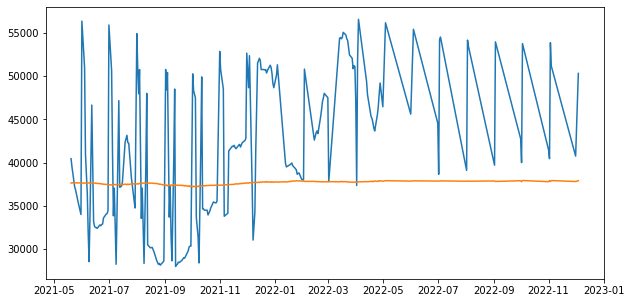

In [ ]:
prediction = forecast_predict(model, test_cabaimerah_, time_size=win_size, batch_size=5)

data_result = prediction[(len(x_train))-win_size:-1, -1 ]
data_result = scal_range.inverse_transform(data_result.reshape(-1, 1))
data_result = data_result.reshape(-1)
mae= tf.keras.metrics.mean_absolute_error(x_test, data_result)
mape = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result)
mse = tf.keras.metrics.mean_squared_error(x_test, data_result)

rmse =math.sqrt(mse.numpy())
print(mae.numpy(), mape.numpy(), rmse)

data_new_cabaimerah = pd.DataFrame()
data_new_cabaimerah['date'] = y_test
data_new_cabaimerah['actual'] = x_test
data_new_cabaimerah['prediction'] = data_result
data_new_cabaimerah.to_csv('cabaimerah_model1_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(data_new_cabaimerah.date, data_new_cabaimerah.actual)
plt.plot(data_new_cabaimerah.date, data_new_cabaimerah.prediction)
data_new_cabaimerah

#### type2

In [ ]:
history_t1 = model.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 28s 39ms/step - loss: 0.0331 - mae: 0.1415 - mape: 330581.0938 - val_loss: 0.1139 - val_mae: 0.2864 - val_mape: 51.3929
Epoch 2/30
718/718 [==============================] - 28s 39ms/step - loss: 0.0329 - mae: 0.1417 - mape: 330834.1250 - val_loss: 0.1090 - val_mae: 0.2801 - val_mape: 50.9593
Epoch 3/30
718/718 [==============================] - 27s 38ms/step - loss: 0.0326 - mae: 0.1412 - mape: 333729.9062 - val_loss: 0.1092 - val_mae: 0.2804 - val_mape: 51.0141
Epoch 4/30
718/718 [==============================] - 28s 39ms/step - loss: 0.0326 - mae: 0.1410 - mape: 384167.4062 - val_loss: 0.1097 - val_mae: 0.2809 - val_mape: 51.0631
Epoch 5/30
718/718 [==============================] - 28s 39ms/step - loss: 0.0326 - mae: 0.1411 - mape: 328184.1562 - val_loss: 0.1053 - val_mae: 0.2753 - val_mape: 50.7237
Epoch 6/30
718/718 [==============================] - 28s 40ms/step - loss: 0.0324 - mae: 0.1404 - mape: 321842.6250 - val_loss: 0

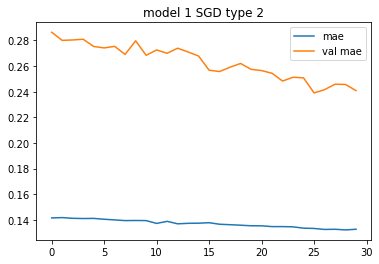

In [ ]:
mae_t1 = history_t1.history['mae']
val_mae_t1 = history_t1.history['val_mae']
epoch_t1 = range(len(mae_t1))

plt.title('model 1 SGD type 2')
plt.plot(epoch_t1, mae_t1, label='mae')
plt.plot(epoch_t1, val_mae_t1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 6ms/step
6675.465 15.74084 8063.378944338409


,date,actual,prediction
0,2021-05-20,40450,37632.074219
1,2021-05-21,39500,37665.542969
2,2021-05-24,37200,37639.261719
3,2021-05-25,36850,37667.484375
4,2021-05-27,35850,37643.062500
...,...,...,...
229,2022-11-02,40450,37922.511719
230,2022-11-03,53850,37814.199219
231,2022-11-04,51150,37925.097656
232,2022-12-01,40750,37813.335938


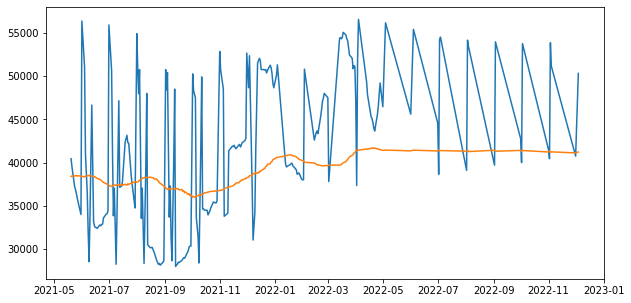

In [ ]:
win_size1 = 60
test_cabaimerah_1 = scal_range.fit_transform(forecast.reshape(-1, 1))
prediction_1 = forecast_predict(model, test_cabaimerah_1, time_size=win_size1, batch_size=5)

data_result_1 = prediction_1[(len(x_train))-win_size1:-1, -1 ]
data_result_1 = scal_range.inverse_transform(data_result_1.reshape(-1, 1))
data_result_1 = data_result_1.reshape(-1)
mae_1= tf.keras.metrics.mean_absolute_error(x_test, data_result_1)
mape_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_1)
mse_1 = tf.keras.metrics.mean_squared_error(x_test, data_result_1)
rmse_1 =math.sqrt(mse_1.numpy())
print(mae_1.numpy(), mape_1.numpy(), rmse_1)

data_new_cabaimerah_1 = pd.DataFrame()
data_new_cabaimerah_1['actual'] = x_test
data_new_cabaimerah_1['prediction'] = data_result_1
data_new_cabaimerah_1.to_csv('cabaimerah_model1_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_cabaimerah_1.actual)
plt.plot(y_test, data_new_cabaimerah_1.prediction)
data_new_cabaimerah

#### type3

In [ ]:
history_t2 = model.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 12s 141ms/step - loss: 0.0387 - mae: 0.1566 - mape: 595731.8750 - val_loss: 0.0723 - val_mae: 0.2261 - val_mape: 49.0929
Epoch 2/30
84/84 [==============================] - 11s 131ms/step - loss: 0.0381 - mae: 0.1581 - mape: 625180.7500 - val_loss: 0.0694 - val_mae: 0.2221 - val_mape: 49.3165
Epoch 3/30
84/84 [==============================] - 11s 130ms/step - loss: 0.0380 - mae: 0.1583 - mape: 637039.2500 - val_loss: 0.0691 - val_mae: 0.2218 - val_mape: 49.3575
Epoch 4/30
84/84 [==============================] - 11s 131ms/step - loss: 0.0380 - mae: 0.1586 - mape: 638366.5625 - val_loss: 0.0682 - val_mae: 0.2205 - val_mape: 49.4755
Epoch 5/30
84/84 [==============================] - 11s 129ms/step - loss: 0.0379 - mae: 0.1582 - mape: 629143.0000 - val_loss: 0.0670 - val_mae: 0.2189 - val_mape: 49.6122
Epoch 6/30
84/84 [==============================] - 11s 129ms/step - loss: 0.0378 - mae: 0.1586 - mape: 649738.6250 - val_loss: 0.0670 

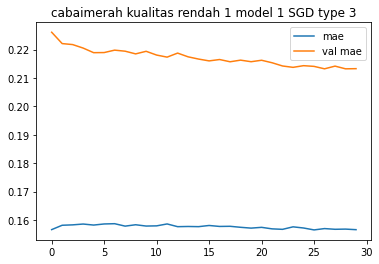

In [ ]:
mae_t2 = history_t2.history['mae']
val_mae_t2 = history_t2.history['val_mae']
epoch_t2 = range(len(mae_t2))

plt.title('cabaimerah kualitas rendah 1 model 1 SGD type 3')
plt.plot(epoch_t2, mae_t2, label='mae')
plt.plot(epoch_t2, val_mae_t2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 2s 12ms/step
6448.4023 15.976768 7486.266626296448


,actual,prediction
0,40450,40165.636719
1,39500,40254.976562
2,37200,40233.929688
3,36850,40302.214844
4,35850,40257.437500
...,...,...
229,40450,44053.964844
230,53850,43814.734375
231,51150,43910.898438
232,40750,43758.382812


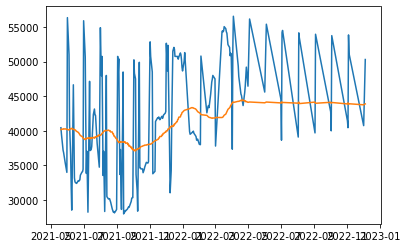

In [ ]:
win_size2 = 150
prediction_2 = forecast_predict(model, test_cabaimerah_, time_size=win_size2, batch_size=5)

data_result_2 = prediction_2[(len(x_train))-win_size2:-1, -1 ]
data_result_2 = scal_range.inverse_transform(data_result_2.reshape(-1, 1))
data_result_2 = data_result_2.reshape(-1)
mae_2= tf.keras.metrics.mean_absolute_error(x_test, data_result_2)
mape_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_2)
mse_2 = tf.keras.metrics.mean_squared_error(x_test, data_result_2)

rmse_2 =math.sqrt(mse_2.numpy())
print(mae_2.numpy(), mape_2.numpy(), rmse_2)

data_new_cabaimerah_2 = pd.DataFrame()
# data_new_cabaimerah1['date'] = date_test
data_new_cabaimerah_2['actual'] = x_test
data_new_cabaimerah_2['prediction'] = data_result_2
data_new_cabaimerah_2.to_csv('cabaimerah_model1_sgd_type3')

plt.plot(y_test, data_new_cabaimerah_2.actual)
plt.plot(y_test, data_new_cabaimerah_2.prediction)
data_new_cabaimerah_2

### Adam

In [ ]:
model_a= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
        LSTM(24, return_sequences=True),
        LSTM(20),
        Dense(64, activation='relu'),
        Dense(1)
])

model_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model_a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 16)          48        
                                                                 
 lstm_2 (LSTM)               (None, None, 24)          3936      
                                                                 
 lstm_3 (LSTM)               (None, 20)                3600      
                                                                 
 dense_2 (Dense)             (None, 64)                1344      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


#### Type 1

In [ ]:
history_a = model_a.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 14s 222ms/step - loss: 0.0777 - mae: 0.2331 - mape: 90.1387 - val_loss: 0.2811 - val_mae: 0.4812 - val_mape: 86.8798
Epoch 2/30
44/44 [==============================] - 9s 196ms/step - loss: 0.0548 - mae: 0.1836 - mape: 64.5272 - val_loss: 0.1839 - val_mae: 0.3699 - val_mape: 61.0020
Epoch 3/30
44/44 [==============================] - 9s 200ms/step - loss: 0.0294 - mae: 0.1315 - mape: 63.8093 - val_loss: 0.0786 - val_mae: 0.2364 - val_mape: 49.1959
Epoch 4/30
44/44 [==============================] - 9s 204ms/step - loss: 0.0217 - mae: 0.1301 - mape: 90.3154 - val_loss: 0.0745 - val_mae: 0.2293 - val_mape: 48.9280
Epoch 5/30
44/44 [==============================] - 9s 199ms/step - loss: 0.0217 - mae: 0.1302 - mape: 91.6077 - val_loss: 0.0715 - val_mae: 0.2250 - val_mape: 49.0995
Epoch 6/30
44/44 [==============================] - 9s 197ms/step - loss: 0.0216 - mae: 0.1314 - mape: 95.8280 - val_loss: 0.0749 - val_mae: 0.2299 - val_mape:

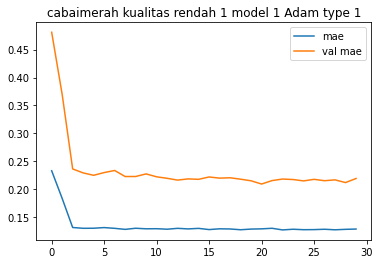

In [ ]:
mae_a = history_a.history['mae']
val_mae_a = history_a.history['val_mae']
epoch_a = range(len(mae_a))

plt.title('cabaimerah kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a, mae_a, label='mae')
plt.plot(epoch_a, val_mae_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 4s 23ms/step
6344.936 15.047 7661.186592167039


,actual,prediction
0,40450,38645.906250
1,39500,38739.355469
2,37200,38730.855469
3,36850,38787.871094
4,35850,38736.578125
...,...,...
229,40450,43092.226562
230,53850,42653.753906
231,51150,42897.121094
232,40750,42624.140625


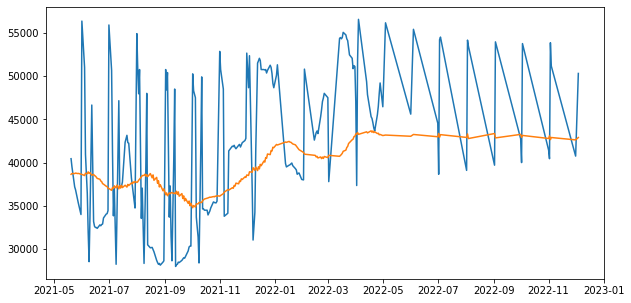

In [ ]:
prediction_a = forecast_predict(model_a, test_cabaimerah_, time_size=win_size, batch_size=5)

data_result_a = prediction_a[(len(x_train))-win_size:-1, -1 ]
data_result_a = scal_range.inverse_transform(data_result_a.reshape(-1, 1))
data_result_a = data_result_a.reshape(-1)
mae_a= tf.keras.metrics.mean_absolute_error(x_test, data_result_a)
mape_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a)
mse_a = tf.keras.metrics.mean_squared_error(x_test, data_result_a)

rmse_a =math.sqrt(mse_a.numpy())
print(mae_a.numpy(), mape_a.numpy(), rmse_a)

data_new_cabaimerah_a = pd.DataFrame()
# data_new_cabaimerah1['date'] = date_test
data_new_cabaimerah_a['actual'] = x_test
data_new_cabaimerah_a['prediction'] = data_result_a
data_new_cabaimerah_a.to_csv('cabaimerah_model1_adam_type1.csv')

plt.figure(figsize=(10,5))
plt.plot(y_test, data_new_cabaimerah_a.actual)
plt.plot(y_test, data_new_cabaimerah_a.prediction)
data_new_cabaimerah_a

#### Type 2

In [29]:
history_a1 = model_a.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 28s 39ms/step - loss: 0.0271 - mae: 0.1271 - mape: 267686.5000 - val_loss: 0.0566 - val_mae: 0.2055 - val_mape: 53.5565
Epoch 2/30
718/718 [==============================] - 29s 40ms/step - loss: 0.0271 - mae: 0.1253 - mape: 301003.0000 - val_loss: 0.0563 - val_mae: 0.2051 - val_mape: 53.9283
Epoch 3/30
718/718 [==============================] - 29s 40ms/step - loss: 0.0269 - mae: 0.1251 - mape: 301906.1250 - val_loss: 0.0547 - val_mae: 0.2032 - val_mape: 55.2049
Epoch 4/30
718/718 [==============================] - 28s 39ms/step - loss: 0.0267 - mae: 0.1237 - mape: 383879.6562 - val_loss: 0.0550 - val_mae: 0.2036 - val_mape: 54.9396
Epoch 5/30
718/718 [==============================] - 28s 39ms/step - loss: 0.0266 - mae: 0.1244 - mape: 270906.5000 - val_loss: 0.0614 - val_mae: 0.2131 - val_mape: 52.3259
Epoch 6/30
718/718 [==============================] - 28s 38ms/step - loss: 0.0261 - mae: 0.1225 - mape: 293650.4375 - val_loss: 0

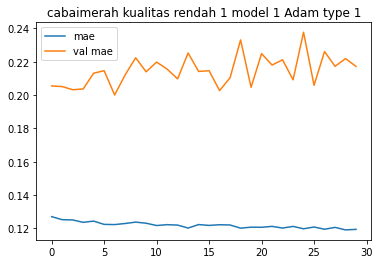

In [30]:
mae_a1 = history_a1.history['mae']
val_mae_a1 = history_a1.history['val_mae']
epoch_a1 = range(len(mae_a1))

plt.title('cabaimerah kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a1, mae_a1, label='mae')
plt.plot(epoch_a1, val_mae_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 2s 9ms/step
6736.5396 17.811289 7984.73243133419


,actual,prediction
0,40450,45147.671875
1,39500,45102.007812
2,37200,45036.449219
3,36850,44964.277344
4,35850,44757.675781
...,...,...
229,40450,49528.507812
230,53850,48154.000000
231,51150,48738.507812
232,40750,48076.898438


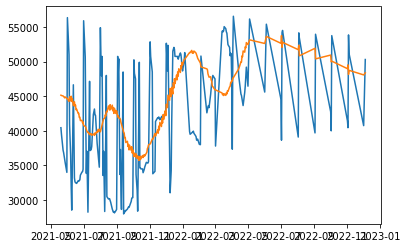

In [31]:
prediction_a1 = forecast_predict(model_a, test_cabaimerah_, time_size=win_size1, batch_size=5)

data_result_a1 = prediction_a1[(len(x_train))-win_size1:-1, -1 ]
data_result_a1 = scal_range.inverse_transform(data_result_a1.reshape(-1, 1))
data_result_a1 = data_result_a1.reshape(-1)
mae_a1= tf.keras.metrics.mean_absolute_error(x_test, data_result_a1)
mape_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a1)
mse_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result_a1)

rmse_a1 =math.sqrt(mse_a1.numpy())
print(mae_a1.numpy(), mape_a1.numpy(), rmse_a1)

data_new_cabaimerah_a1 = pd.DataFrame()
data_new_cabaimerah_a1['actual'] = x_test
data_new_cabaimerah_a1['prediction'] = data_result_a1
data_new_cabaimerah_a1.to_csv('cabaimerah_model1_adam_type2.csv')

plt.plot(y_test, data_new_cabaimerah_a1.actual)
plt.plot(y_test, data_new_cabaimerah_a1.prediction)
data_new_cabaimerah_a1

#### Type 3

In [32]:
history_a2 = model_a.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 12s 136ms/step - loss: 0.0320 - mae: 0.1419 - mape: 541099.2500 - val_loss: 0.0714 - val_mae: 0.2234 - val_mape: 48.9191
Epoch 2/30
84/84 [==============================] - 11s 132ms/step - loss: 0.0319 - mae: 0.1418 - mape: 519332.6250 - val_loss: 0.0694 - val_mae: 0.2203 - val_mape: 49.0897
Epoch 3/30
84/84 [==============================] - 13s 152ms/step - loss: 0.0318 - mae: 0.1412 - mape: 531270.6250 - val_loss: 0.0680 - val_mae: 0.2185 - val_mape: 49.3208
Epoch 4/30
84/84 [==============================] - 11s 132ms/step - loss: 0.0319 - mae: 0.1419 - mape: 551270.1875 - val_loss: 0.0693 - val_mae: 0.2203 - val_mape: 49.1294
Epoch 5/30
84/84 [==============================] - 11s 132ms/step - loss: 0.0319 - mae: 0.1416 - mape: 538332.1250 - val_loss: 0.0720 - val_mae: 0.2242 - val_mape: 48.8580
Epoch 6/30
84/84 [==============================] - 11s 131ms/step - loss: 0.0321 - mae: 0.1414 - mape: 524009.2188 - val_loss: 0.0731 

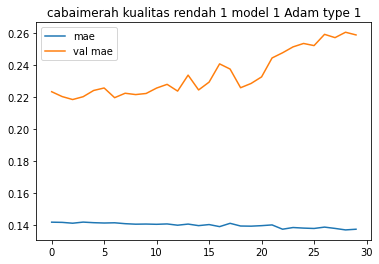

In [33]:
mae_a2 = history_a2.history['mae']
val_mae_a2 = history_a2.history['val_mae']
epoch_a2 = range(len(mae_a2))

plt.title('cabaimerah kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a2, mae_a2, label='mae')
plt.plot(epoch_a2, val_mae_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 2s 11ms/step
7236.937 18.216919 8689.847869784602


,actual,prediction
0,40450,46844.664062
1,39500,46065.375000
2,37200,47166.304688
3,36850,46319.296875
4,35850,47264.601562
...,...,...
229,40450,44326.675781
230,53850,43475.054688
231,51150,43672.171875
232,40750,43424.617188


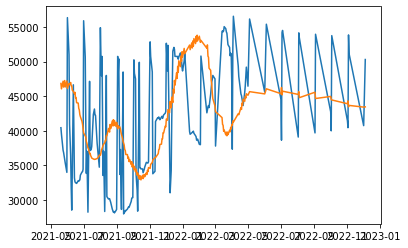

In [34]:
prediction_a2 = forecast_predict(model_a, test_cabaimerah_, time_size=win_size2, batch_size=5)

data_result_a2 = prediction_a2[(len(x_train))-win_size2:-1, -1 ]
data_result_a2 = scal_range.inverse_transform(data_result_a2.reshape(-1, 1))
data_result_a2 = data_result_a2.reshape(-1)
mae_a2= tf.keras.metrics.mean_absolute_error(x_test, data_result_a2)
mape_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a2)
mse_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result_a2)

rmse_a2 =math.sqrt(mse_a2.numpy())
print(mae_a2.numpy(), mape_a2.numpy(), rmse_a2)

data_new_cabaimerah_a2 = pd.DataFrame()
# data_new_cabaimerah1['date'] = date_test
data_new_cabaimerah_a2['actual'] = x_test
data_new_cabaimerah_a2['prediction'] = data_result_a2
data_new_cabaimerah_a2.to_csv('cabaimerah_model1_adam_type3.csv')

plt.plot(y_test, data_new_cabaimerah_a2.actual)
plt.plot(y_test, data_new_cabaimerah_a2.prediction)
data_new_cabaimerah_a2

## model 1

### Adam

In [35]:
model1= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['mae', 'mape'])
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_4 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_5 (LSTM)               (None, 32)                20608     
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

#### Type 1

In [36]:
history1 = model1.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 21s 342ms/step - loss: 0.0568 - mae: 0.1856 - mape: 67.1746 - val_loss: 0.0918 - val_mae: 0.2566 - val_mape: 49.6854
Epoch 2/15
44/44 [==============================] - 14s 315ms/step - loss: 0.0225 - mae: 0.1336 - mape: 95.9830 - val_loss: 0.0692 - val_mae: 0.2210 - val_mape: 48.8169
Epoch 3/15
44/44 [==============================] - 14s 319ms/step - loss: 0.0220 - mae: 0.1303 - mape: 88.8840 - val_loss: 0.0619 - val_mae: 0.2109 - val_mape: 49.9328
Epoch 4/15
44/44 [==============================] - 14s 318ms/step - loss: 0.0224 - mae: 0.1320 - mape: 92.2011 - val_loss: 0.0655 - val_mae: 0.2161 - val_mape: 49.3476
Epoch 5/15
44/44 [==============================] - 14s 320ms/step - loss: 0.0225 - mae: 0.1313 - mape: 87.3071 - val_loss: 0.0576 - val_mae: 0.2054 - val_mape: 51.3149
Epoch 6/15
44/44 [==============================] - 16s 362ms/step - loss: 0.0223 - mae: 0.1331 - mape: 94.8529 - val_loss: 0.0686 - val_mae: 0.2203 - val_

17/17 [==============================] - 0s 16ms/step - loss: 0.0862 - mae: 0.2403 - mape: 32.1995


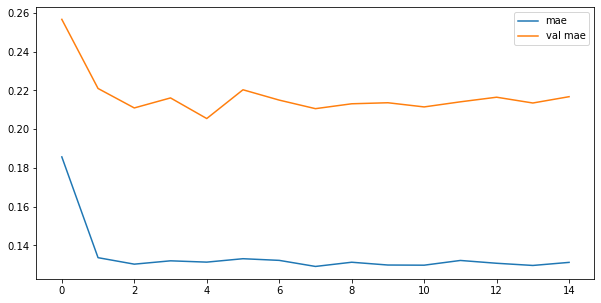

In [37]:
model1.evaluate(test_step)
mae1 = history1.history['mae']
val_mae1 = history1.history['val_mae']
epoch1 = range(len(mae1))

plt.figure(figsize=(10, 5))
plt.plot(epoch1, mae1, label='mae')
plt.plot(epoch1, val_mae1, label='val mae')
plt.legend()
plt.show()

In [38]:
prediction1 = forecast_predict(model1, test_cabaimerah_, time_size=win_size, batch_size=5)

data_result1 = prediction1[(len(x_train))-win_size:-1, -1 ]
data_result1 = scal_range.inverse_transform(data_result1.reshape(-1, 1))
data_result1 = data_result1.reshape(-1)
mae1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1)
mape1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1)
mse1 = tf.keras.metrics.mean_squared_error(x_test, data_result1)

rmse1 = math.sqrt(mse1.numpy())
print(mae1.numpy(), mape1.numpy(), rmse1)

data_new_cabaimerah1 = pd.DataFrame()
data_new_cabaimerah1['actual'] = x_test
data_new_cabaimerah1['prediction'] = data_result1
data_new_cabaimerah1.to_csv('cabaimerah_model2_adam_type1.csv')

data_new_cabaimerah1

131/131 [==============================] - 5s 33ms/step
6443.8306 15.34334 7750.903689248113


,actual,prediction
0,40450,38681.351562
1,39500,38795.554688
2,37200,38750.480469
3,36850,38859.773438
4,35850,38809.417969
...,...,...
229,40450,43155.683594
230,53850,43072.906250
231,51150,43058.175781
232,40750,42964.402344


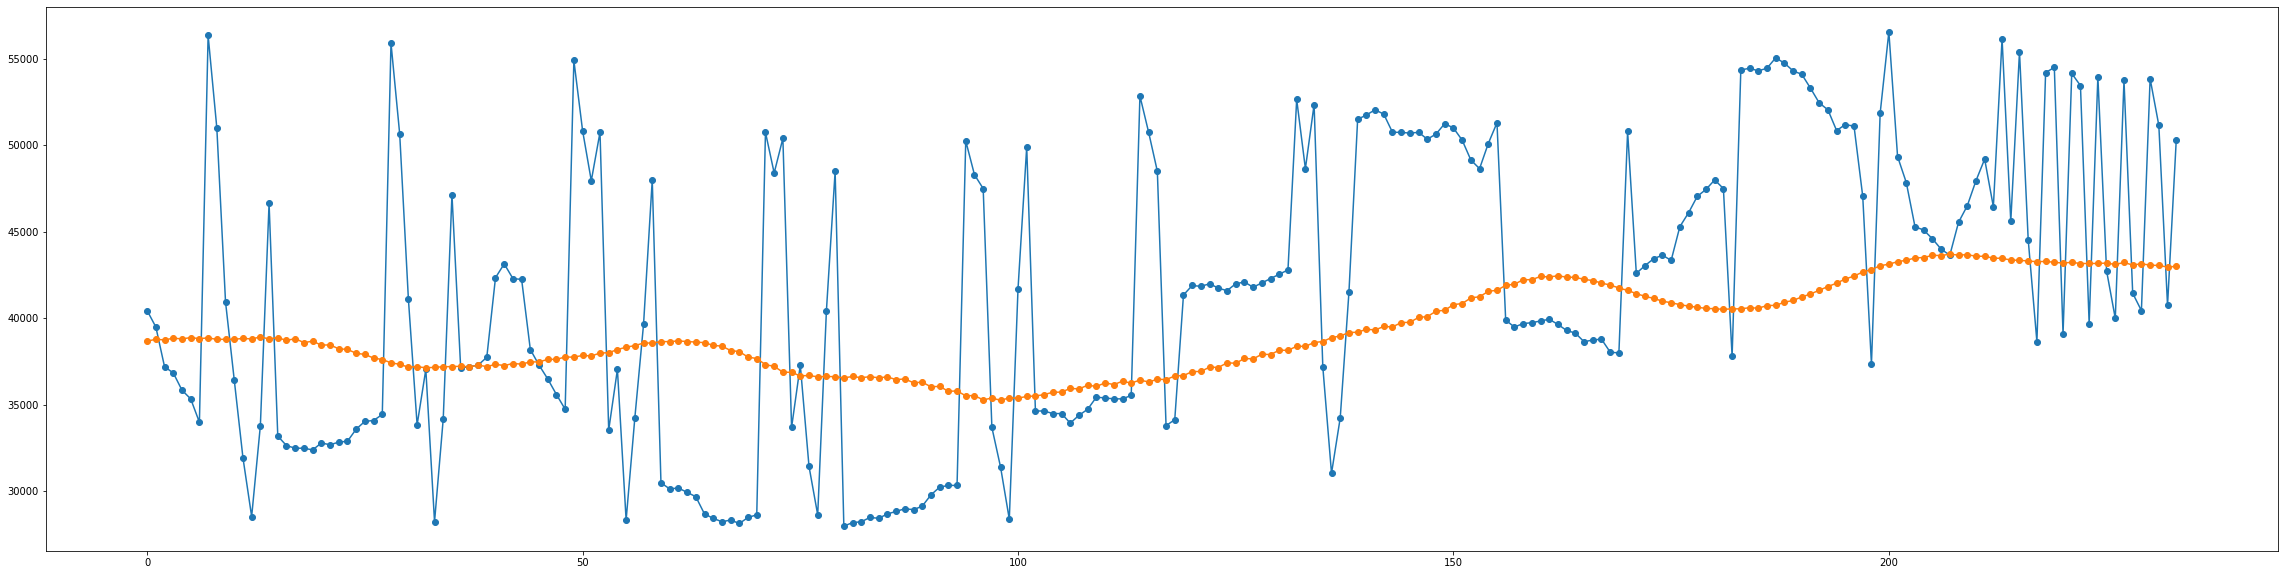

In [39]:
plt.figure(figsize=(40, 10))
plt.plot(range(len(x_test)), data_new_cabaimerah1['actual'], '-o')
plt.plot(range(len(x_test)), data_new_cabaimerah1['prediction'], '-o')

#### Type 2

In [40]:
history1_1 = model1.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 31s 43ms/step - loss: 0.0275 - mae: 0.1281 - mape: 385205.1562 - val_loss: 0.0579 - val_mae: 0.2067 - val_mape: 52.4212
Epoch 2/15
718/718 [==============================] - 32s 44ms/step - loss: 0.0264 - mae: 0.1247 - mape: 270170.4375 - val_loss: 0.0626 - val_mae: 0.2123 - val_mape: 50.6384
Epoch 3/15
718/718 [==============================] - 32s 44ms/step - loss: 0.0269 - mae: 0.1265 - mape: 341806.7188 - val_loss: 0.0694 - val_mae: 0.2208 - val_mape: 49.4605
Epoch 4/15
718/718 [==============================] - 31s 43ms/step - loss: 0.0266 - mae: 0.1256 - mape: 279445.4062 - val_loss: 0.0743 - val_mae: 0.2275 - val_mape: 49.3100
Epoch 5/15
718/718 [==============================] - 31s 43ms/step - loss: 0.0260 - mae: 0.1233 - mape: 264881.9062 - val_loss: 0.0659 - val_mae: 0.2154 - val_mape: 50.5854
Epoch 6/15
718/718 [==============================] - 31s 43ms/step - loss: 0.0264 - mae: 0.1241 - mape: 258592.7969 - val_loss: 0

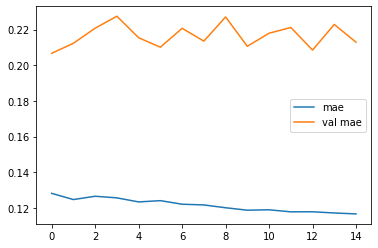

In [41]:
mae1_1 = history1_1.history['mae']
val_mae1_1 = history1_1.history['val_mae']
epoch1_1 = range(len(mae1_1))

plt.plot(epoch1_1, mae1_1, label='mae')
plt.plot(epoch1_1, val_mae1_1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 2s 9ms/step
6751.4067 15.929449 7750.903689248113


,actual,prediction
0,40450,42467.710938
1,39500,42408.425781
2,37200,41868.609375
3,36850,41865.949219
4,35850,41242.906250
...,...,...
229,40450,38552.390625
230,53850,38582.722656
231,51150,38312.972656
232,40750,38345.410156


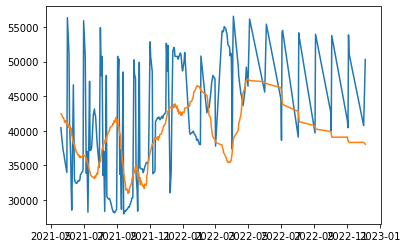

In [42]:
prediction1_1 = forecast_predict(model1, test_cabaimerah_, time_size=win_size1, batch_size=5)

data_result1_1 = prediction1_1[(len(x_train))-win_size1:-1, -1 ]
data_result1_1 = scal_range.inverse_transform(data_result1_1.reshape(-1, 1))
data_result1_1 = data_result1_1.reshape(-1)
mae1_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_1)
mape1_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_1)
mse1_1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_1)

rmse1_1 = math.sqrt(mse1.numpy())
print(mae1_1.numpy(), mape1_1.numpy(), rmse1_1)

data_new_cabaimerah1_1 = pd.DataFrame()
data_new_cabaimerah1_1['actual'] = x_test
data_new_cabaimerah1_1['prediction'] = data_result1_1
data_new_cabaimerah1_1.to_csv('cabaimerah_model2_adam_type2.csv')

plt.plot(y_test, data_new_cabaimerah1_1.actual)
plt.plot(y_test, data_new_cabaimerah1_1.prediction)
data_new_cabaimerah1_1

#### Type 3

In [43]:
history1_2 = model1.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 18s 213ms/step - loss: 0.0317 - mae: 0.1417 - mape: 422119.6250 - val_loss: 0.0632 - val_mae: 0.2104 - val_mape: 49.4519
Epoch 2/15
84/84 [==============================] - 18s 211ms/step - loss: 0.0308 - mae: 0.1387 - mape: 433640.3438 - val_loss: 0.0684 - val_mae: 0.2161 - val_mape: 48.9193
Epoch 3/15
84/84 [==============================] - 18s 213ms/step - loss: 0.0303 - mae: 0.1361 - mape: 421871.2500 - val_loss: 0.0682 - val_mae: 0.2155 - val_mape: 49.3654
Epoch 4/15
84/84 [==============================] - 18s 213ms/step - loss: 0.0303 - mae: 0.1359 - mape: 419972.4688 - val_loss: 0.0733 - val_mae: 0.2219 - val_mape: 47.8433
Epoch 5/15
84/84 [==============================] - 18s 214ms/step - loss: 0.0299 - mae: 0.1344 - mape: 367558.5000 - val_loss: 0.0717 - val_mae: 0.2213 - val_mape: 47.5956
Epoch 6/15
84/84 [==============================] - 18s 212ms/step - loss: 0.0300 - mae: 0.1340 - mape: 437459.2188 - val_loss: 0.0724 

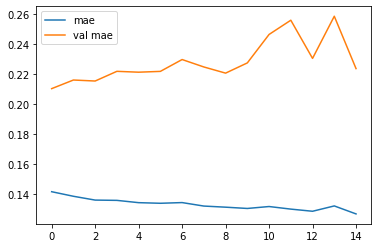

In [44]:
mae1_2 = history1_2.history['mae']
val_mae1_2 = history1_2.history['val_mae']
epoch1_2 = range(len(mae1_2))

plt.plot(epoch1_2, mae1_2, label='mae')
plt.plot(epoch1_2, val_mae1_2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 3s 15ms/step
7046.2607 17.678183 7750.903689248113


,actual,prediction
0,40450,46179.574219
1,39500,47246.105469
2,37200,45966.605469
3,36850,47061.878906
4,35850,45623.320312
...,...,...
229,40450,44372.347656
230,53850,44408.050781
231,51150,44055.125000
232,40750,44090.000000


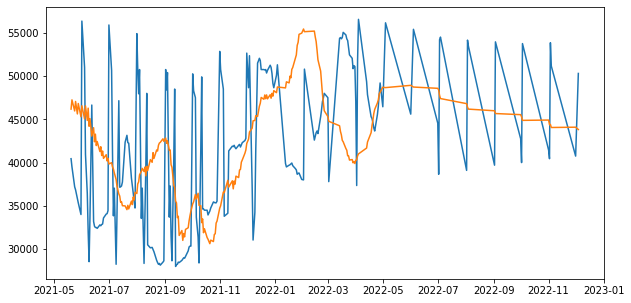

In [45]:
prediction1_2 = forecast_predict(model1, test_cabaimerah_, time_size=win_size2, batch_size=5)

data_result1_2 = prediction1_2[(len(x_train))-win_size2:-1, -1 ]
data_result1_2 = scal_range.inverse_transform(data_result1_2.reshape(-1, 1))
data_result1_2 = data_result1_2.reshape(-1)
mae1_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_2)
mape1_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_2)
mse1_2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_2)
rmse1_2 = math.sqrt(mse1.numpy())
print(mae1_2.numpy(), mape1_2.numpy(), rmse1_2)

data_new_cabaimerah1_2 = pd.DataFrame()
data_new_cabaimerah1_2['actual'] = x_test
data_new_cabaimerah1_2['prediction'] = data_result1_2
data_new_cabaimerah1_2.to_csv('cabaimerah_model2_adam_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_cabaimerah1_2.actual)
plt.plot(y_test, data_new_cabaimerah1_2.prediction)

data_new_cabaimerah1_2

### SGD

In [46]:
model1_a= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1_a.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model1_a.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_6 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_7 (LSTM)               (None, 32)                20608     
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

In [ ]:
# plot_model(model1, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

#### Type1 

In [47]:
history1_a = model1_a.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 19s 343ms/step - loss: 0.0739 - mae: 0.2250 - mape: 85.5508 - val_loss: 0.2779 - val_mae: 0.4779 - val_mape: 86.0637
Epoch 2/15
44/44 [==============================] - 14s 319ms/step - loss: 0.0555 - mae: 0.1835 - mape: 62.8973 - val_loss: 0.2394 - val_mae: 0.4357 - val_mape: 75.6153
Epoch 3/15
44/44 [==============================] - 14s 319ms/step - loss: 0.0437 - mae: 0.1555 - mape: 53.8180 - val_loss: 0.2108 - val_mae: 0.4016 - val_mape: 67.1487
Epoch 4/15
44/44 [==============================] - 14s 317ms/step - loss: 0.0360 - mae: 0.1411 - mape: 55.1121 - val_loss: 0.1902 - val_mae: 0.3775 - val_mape: 62.3696
Epoch 5/15
44/44 [==============================] - 14s 320ms/step - loss: 0.0312 - mae: 0.1347 - mape: 60.3136 - val_loss: 0.1746 - val_mae: 0.3592 - val_mape: 59.1984
Epoch 6/15
44/44 [==============================] - 14s 316ms/step - loss: 0.0281 - mae: 0.1335 - mape: 67.4056 - val_loss: 0.1619 - val_mae: 0.3453 - val_

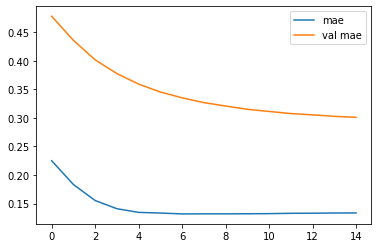

In [48]:
mae1_a = history1_a.history['mae']
val_mae1_a = history1_a.history['val_mae']
epoch1_a = range(len(mae1_a))

plt.plot(epoch1_a, mae1_a, label='mae')
plt.plot(epoch1_a, val_mae1_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 5s 33ms/step
7480.557 17.288002 9081.071742916693


,actual,prediction
0,40450,37514.632812
1,39500,37520.570312
2,37200,37529.812500
3,36850,37533.972656
4,35850,37540.800781
...,...,...
229,40450,37906.062500
230,53850,37929.757812
231,51150,37894.394531
232,40750,37911.691406


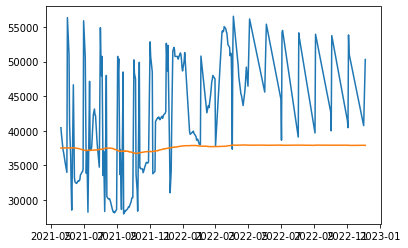

In [49]:
prediction1_a = forecast_predict(model1_a, test_cabaimerah_, time_size=win_size, batch_size=5)

data_result1_a = prediction1_a[(len(x_train))-win_size:-1, -1 ]
data_result1_a = scal_range.inverse_transform(data_result1_a.reshape(-1, 1))
data_result1_a = data_result1_a.reshape(-1)
mae1_a = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a)
mape1_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a)
mse1_a = tf.keras.metrics.mean_squared_error(x_test, data_result1_a)

rmse1_a = math.sqrt(mse1_a.numpy())
print(mae1_a.numpy(), mape1_a.numpy(), rmse1_a)

data_new_cabaimerah1_a = pd.DataFrame()
data_new_cabaimerah1_a['actual'] = x_test
data_new_cabaimerah1_a['prediction'] = data_result1_a
data_new_cabaimerah1_a.to_csv('cabaimerah_model2_sgd_type1.csv')


plt.plot(y_test, data_new_cabaimerah1_a.actual)
plt.plot(y_test, data_new_cabaimerah1_a.prediction)

data_new_cabaimerah1_a

#### Type 2


In [50]:
history1_a1 = model1_a.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 31s 43ms/step - loss: 0.0323 - mae: 0.1402 - mape: 311896.3438 - val_loss: 0.1017 - val_mae: 0.2704 - val_mape: 50.3510
Epoch 2/15
718/718 [==============================] - 31s 43ms/step - loss: 0.0312 - mae: 0.1380 - mape: 321957.6250 - val_loss: 0.1048 - val_mae: 0.2746 - val_mape: 50.7036
Epoch 3/15
718/718 [==============================] - 34s 47ms/step - loss: 0.0312 - mae: 0.1377 - mape: 388975.3438 - val_loss: 0.0964 - val_mae: 0.2632 - val_mape: 50.0253
Epoch 4/15
718/718 [==============================] - 31s 44ms/step - loss: 0.0304 - mae: 0.1349 - mape: 301219.5938 - val_loss: 0.1015 - val_mae: 0.2702 - val_mape: 50.4449
Epoch 5/15
718/718 [==============================] - 31s 44ms/step - loss: 0.0306 - mae: 0.1366 - mape: 308129.4375 - val_loss: 0.0947 - val_mae: 0.2609 - val_mape: 49.9904
Epoch 6/15
718/718 [==============================] - 31s 43ms/step - loss: 0.0303 - mae: 0.1353 - mape: 336879.2500 - val_loss: 0

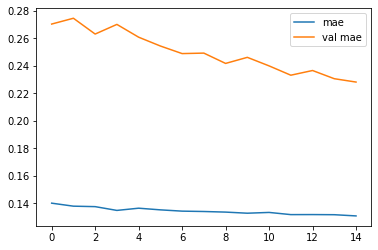

In [51]:
mae1_a1 = history1_a1.history['mae']
val_mae1_a1 = history1_a1.history['val_mae']
epoch1_a1 = range(len(mae1_a1))

plt.plot(epoch1_a1, mae1_a1, label='mae')
plt.plot(epoch1_a1, val_mae1_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 2s 9ms/step
6608.2886 15.763992 7891.3649009534465


,actual,prediction
0,40450,38775.792969
1,39500,38799.503906
2,37200,38849.605469
3,36850,38864.492188
4,35850,38903.859375
...,...,...
229,40450,42138.886719
230,53850,42228.695312
231,51150,42062.742188
232,40750,42149.183594


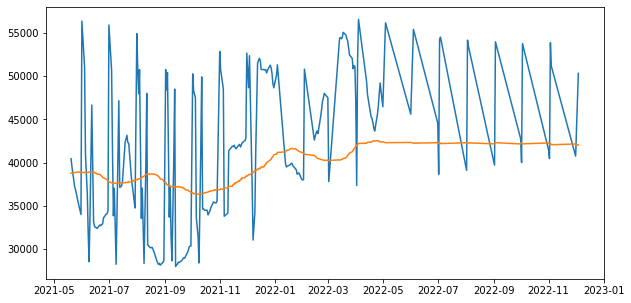

In [52]:
prediction1_a1 = forecast_predict(model1_a, test_cabaimerah_, time_size=win_size1, batch_size=5)

data_result1_a1 = prediction1_a1[(len(x_train))-win_size1:-1, -1 ]
data_result1_a1 = scal_range.inverse_transform(data_result1_a1.reshape(-1, 1))
data_result1_a1 = data_result1_a1.reshape(-1)
mae1_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a1)
mape1_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a1)
mse1_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a1)

rmse1_a1 = math.sqrt(mse1_a1.numpy())
print(mae1_a1.numpy(), mape1_a1.numpy(), rmse1_a1)

data_new_cabaimerah1_a1 = pd.DataFrame()
data_new_cabaimerah1_a1['actual'] = x_test
data_new_cabaimerah1_a1['prediction'] = data_result1_a1
data_new_cabaimerah1_a1.to_csv('cabaimerah_model2_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_cabaimerah1_a1.actual)
plt.plot(y_test, data_new_cabaimerah1_a1.prediction)
data_new_cabaimerah1_a1

#### Type 3

In [56]:
history1_a2 = model1_a.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 26s 303ms/step - loss: 0.0368 - mae: 0.1564 - mape: 598493.8125 - val_loss: 0.0621 - val_mae: 0.2116 - val_mape: 50.1523
Epoch 2/15
84/84 [==============================] - 19s 226ms/step - loss: 0.0368 - mae: 0.1562 - mape: 586490.3750 - val_loss: 0.0618 - val_mae: 0.2112 - val_mape: 50.2018
Epoch 3/15
84/84 [==============================] - 19s 229ms/step - loss: 0.0368 - mae: 0.1567 - mape: 586593.7500 - val_loss: 0.0618 - val_mae: 0.2112 - val_mape: 50.2220
Epoch 4/15
84/84 [==============================] - 20s 234ms/step - loss: 0.0368 - mae: 0.1562 - mape: 596178.1250 - val_loss: 0.0614 - val_mae: 0.2107 - val_mape: 50.2743
Epoch 5/15
84/84 [==============================] - 18s 217ms/step - loss: 0.0367 - mae: 0.1564 - mape: 595020.1250 - val_loss: 0.0609 - val_mae: 0.2100 - val_mape: 50.3927
Epoch 6/15
84/84 [==============================] - 18s 215ms/step - loss: 0.0366 - mae: 0.1559 - mape: 589751.5000 - val_loss: 0.0611 

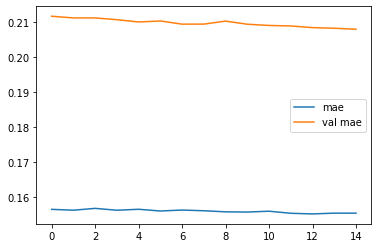

In [57]:
mae1_a2 = history1_a2.history['mae']
val_mae1_a2 = history1_a2.history['val_mae']
epoch1_a2 = range(len(mae1_a2))

plt.plot(epoch1_a2, mae1_a2, label='mae')
plt.plot(epoch1_a2, val_mae1_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 3s 17ms/step
6390.916 15.865384 7431.999192680258


,actual,prediction
0,40450,40206.710938
1,39500,40234.175781
2,37200,40301.003906
3,36850,40318.164062
4,35850,40371.179688
...,...,...
229,40450,44707.382812
230,53850,44818.738281
231,51150,44614.472656
232,40750,44720.183594


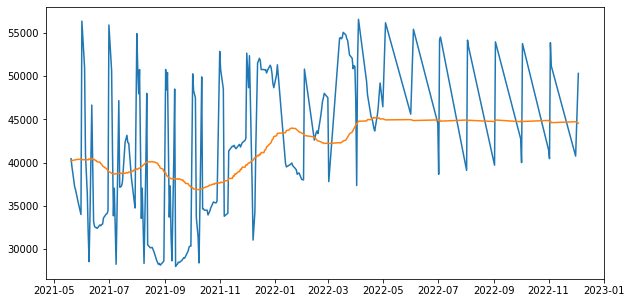

In [58]:
prediction1_a2 = forecast_predict(model1_a, test_cabaimerah_, time_size=win_size2, batch_size=5)

data_result1_a2 = prediction1_a2[(len(x_train))-win_size2:-1, -1 ]
data_result1_a2 = scal_range.inverse_transform(data_result1_a2.reshape(-1, 1))
data_result1_a2 = data_result1_a2.reshape(-1)
mae1_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a2)
mape1_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a2)
mse1_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a2)

rmse1_a2 = math.sqrt(mse1_a2.numpy())
print(mae1_a2.numpy(), mape1_a2.numpy(), rmse1_a2)

data_new_cabaimerah1_a2 = pd.DataFrame()
data_new_cabaimerah1_a2['actual'] = x_test
data_new_cabaimerah1_a2['prediction'] = data_result1_a2
data_new_cabaimerah1_a2.to_csv('cabaimerah_model2_sgd_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_cabaimerah1_a2.actual)
plt.plot(y_test, data_new_cabaimerah1_a2.prediction)

data_new_cabaimerah1_a2

## model 2

### SGD

In [59]:
model2= Sequential([
    Conv1D(8, kernel_size=5, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(14, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(24, activation='relu'),
    Dense(550, activation='relu'),
    Dense(1)
])

model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, None, 8)           48        
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 8)          0         
 )                                                               
                                                                 
 lstm_8 (LSTM)               (None, None, 14)          1288      
                                                                 
 dropout (Dropout)           (None, None, 14)          0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                20224     
                                                                 
 dense_10 (Dense)            (None, 24)                1560      
                                                      

In [ ]:
# plot_model(model2, to_file='model3_plot.png', show_shapes=True, show_layer_names=True)

#### Type 1

In [61]:
history2 = model2.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 5s 121ms/step - loss: 0.0232 - mae: 0.1362 - mape: 95.0734 - val_loss: 0.1260 - val_mae: 0.3025 - val_mape: 52.9198
Epoch 2/50
44/44 [==============================] - 8s 193ms/step - loss: 0.0231 - mae: 0.1361 - mape: 95.1495 - val_loss: 0.1261 - val_mae: 0.3026 - val_mape: 52.9348
Epoch 3/50
44/44 [==============================] - 10s 217ms/step - loss: 0.0231 - mae: 0.1359 - mape: 94.8789 - val_loss: 0.1263 - val_mae: 0.3029 - val_mape: 52.9615
Epoch 4/50
44/44 [==============================] - 7s 161ms/step - loss: 0.0231 - mae: 0.1360 - mape: 94.8354 - val_loss: 0.1261 - val_mae: 0.3026 - val_mape: 52.9314
Epoch 5/50
44/44 [==============================] - 5s 114ms/step - loss: 0.0230 - mae: 0.1358 - mape: 94.9315 - val_loss: 0.1258 - val_mae: 0.3022 - val_mape: 52.8944
Epoch 6/50
44/44 [==============================] - 5s 118ms/step - loss: 0.0231 - mae: 0.1359 - mape: 94.8876 - val_loss: 0.1259 - val_mae: 0.3023 - val_mape:

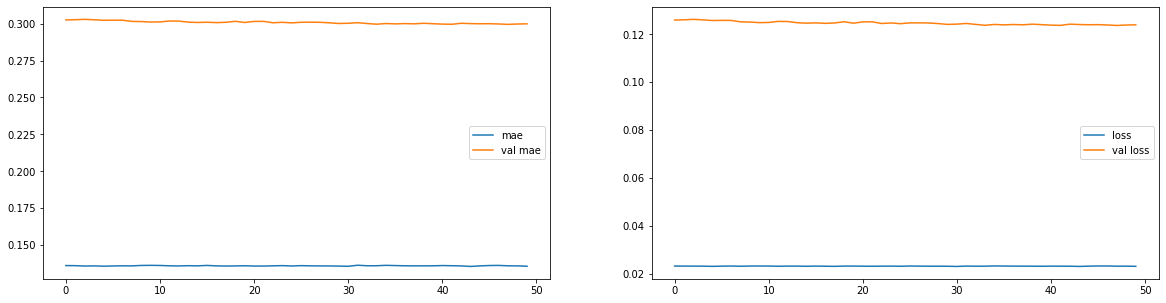

In [62]:
mae2 = history2.history['mae']
val_mae2 = history2.history['val_mae']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epoch2 = range(len(mae2))

plt.figure(figsize=(20, 5))
plt.subplot(1,2, 1)
plt.plot(epoch2, mae2, label='mae')
plt.plot(epoch2, val_mae2, label='val mae')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch2, loss2, label='loss')
plt.plot(epoch2, val_loss2, label='val loss')
plt.legend()
plt.show()

131/131 [==============================] - 3s 16ms/step
7512.1157 17.457407 9065.16585617715


,actual,prediction
0,40450,37535.804688
1,39500,37573.175781
2,37200,37610.355469
3,36850,37598.667969
4,35850,37546.414062
...,...,...
229,40450,38033.136719
230,53850,38057.886719
231,51150,38041.539062
232,40750,38065.460938


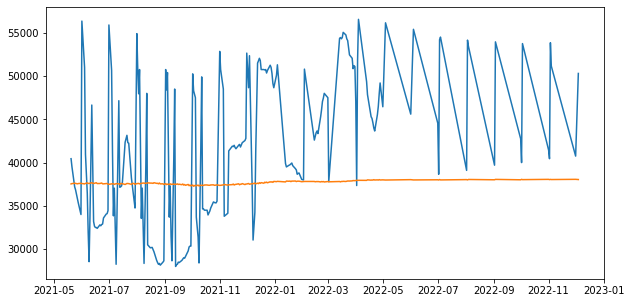

In [63]:
prediction2 = forecast_predict(model2, test_cabaimerah_, time_size=win_size, batch_size=5)

data_result2 = prediction2[(len(x_train))-win_size:-1, -1 ]
data_result2 = scal_range.inverse_transform(data_result2.reshape(-1, 1))
data_result2 = data_result2.reshape(-1)
mae2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2)
mape2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2)
mse2 = tf.keras.metrics.mean_squared_error(x_test, data_result2)

rmse2 = math.sqrt(mse2.numpy())
print(mae2.numpy(), mape2.numpy(), rmse2)

data_new_cabaimerah2 = pd.DataFrame()
data_new_cabaimerah2['actual'] = x_test
data_new_cabaimerah2['prediction'] = data_result2
data_new_cabaimerah2.to_csv('cabaimerah_medium_model3_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_cabaimerah2.actual)
plt.plot(y_test, data_new_cabaimerah2.prediction)
data_new_cabaimerah2

#### Type2

In [64]:
history2_1 = model2.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 16s 22ms/step - loss: 0.0332 - mae: 0.1424 - mape: 362908.5312 - val_loss: 0.1099 - val_mae: 0.2813 - val_mape: 51.0025
Epoch 2/50
718/718 [==============================] - 15s 21ms/step - loss: 0.0330 - mae: 0.1423 - mape: 337905.0625 - val_loss: 0.1093 - val_mae: 0.2805 - val_mape: 50.9584
Epoch 3/50
718/718 [==============================] - 16s 22ms/step - loss: 0.0330 - mae: 0.1417 - mape: 328059.7188 - val_loss: 0.1090 - val_mae: 0.2800 - val_mape: 50.9328
Epoch 4/50
718/718 [==============================] - 16s 22ms/step - loss: 0.0329 - mae: 0.1422 - mape: 328119.9062 - val_loss: 0.1060 - val_mae: 0.2762 - val_mape: 50.6935
Epoch 5/50
718/718 [==============================] - 16s 22ms/step - loss: 0.0328 - mae: 0.1415 - mape: 345633.9062 - val_loss: 0.1092 - val_mae: 0.2803 - val_mape: 50.9537
Epoch 6/50
718/718 [==============================] - 16s 22ms/step - loss: 0.0327 - mae: 0.1414 - mape: 319931.2188 - val_loss: 0

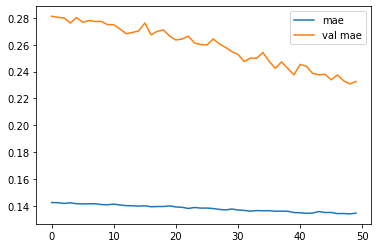

In [65]:
mae2_1 = history2_1.history['mae']
val_mae2_1 = history2_1.history['val_mae']
epoch2_1 = range(len(mae2_1))

plt.plot(epoch2_1, mae2_1, label='mae')
plt.plot(epoch2_1, val_mae2_1, label='val mae')
plt.legend()
plt.show()

In [66]:
prediction2_1 = forecast_predict(model2, test_cabaimerah_, time_size=win_size1, batch_size=5)

data_result2_1 = prediction2_1[(len(x_train))-win_size1:-1, -1 ]
data_result2_1 = scal_range.inverse_transform(data_result2_1.reshape(-1, 1))
data_result2_1 = data_result2_1.reshape(-1)
mae2_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_1)
mape2_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_1)
mse2_1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_1)

rmse2_1 = math.sqrt(mse2_1.numpy())
print(mae2_1.numpy(), mape2_1.numpy(), rmse2_1)

data_new_cabaimerah2_1 = pd.DataFrame()
data_new_cabaimerah2_1['actual'] = x_test
data_new_cabaimerah2_1['prediction'] = data_result2_1
data_new_cabaimerah2_1.to_csv('cabaimerah_model3_sgd_type2.csv')

data_new_cabaimerah2

199/199 [==============================] - 1s 5ms/step
6839.7666 16.102093 8281.49068706836


,actual,prediction
0,40450,37535.804688
1,39500,37573.175781
2,37200,37610.355469
3,36850,37598.667969
4,35850,37546.414062
...,...,...
229,40450,38033.136719
230,53850,38057.886719
231,51150,38041.539062
232,40750,38065.460938


#### Type 3

In [67]:
history2_2 = model2.fit(train_step2, epochs=50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 7s 80ms/step - loss: 0.0397 - mae: 0.1591 - mape: 568969.8125 - val_loss: 0.0713 - val_mae: 0.2239 - val_mape: 48.5828
Epoch 2/50
84/84 [==============================] - 7s 80ms/step - loss: 0.0393 - mae: 0.1596 - mape: 581872.8125 - val_loss: 0.0694 - val_mae: 0.2212 - val_mape: 48.7031
Epoch 3/50
84/84 [==============================] - 7s 80ms/step - loss: 0.0394 - mae: 0.1608 - mape: 594823.6250 - val_loss: 0.0679 - val_mae: 0.2190 - val_mape: 48.8068
Epoch 4/50
84/84 [==============================] - 7s 79ms/step - loss: 0.0394 - mae: 0.1609 - mape: 607669.0000 - val_loss: 0.0675 - val_mae: 0.2184 - val_mape: 48.8397
Epoch 5/50
84/84 [==============================] - 7s 78ms/step - loss: 0.0390 - mae: 0.1608 - mape: 623546.3750 - val_loss: 0.0671 - val_mae: 0.2179 - val_mape: 48.8951
Epoch 6/50
84/84 [==============================] - 7s 78ms/step - loss: 0.0394 - mae: 0.1612 - mape: 618906.6875 - val_loss: 0.0674 - val_mae: 0

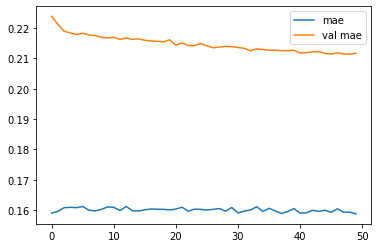

In [68]:
mae2_2 = history2_2.history['mae']
val_mae2_2 = history2_2.history['val_mae']
epoch2_2 = range(len(mae2_2))

plt.plot(epoch2_2, mae2_2, label='mae')
plt.plot(epoch2_2, val_mae2_2, label='val mae')
plt.legend()
plt.show()

In [69]:
prediction2_2 = forecast_predict(model2, test_cabaimerah_, time_size=win_size2, batch_size=5)

data_result2_2 = prediction2_2[(len(x_train))-win_size2:-1, -1 ]
data_result2_2 = scal_range.inverse_transform(data_result2_2.reshape(-1, 1))
data_result2_2 = data_result2_2.reshape(-1)
mae2_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_2)
mape2_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_2)
mse2_2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_2)

rmse2_2 = math.sqrt(mse2_2.numpy())
print(mae2_2.numpy(), mape2_2.numpy(), rmse2_2)

data_new_cabaimerah2_2 = pd.DataFrame()
data_new_cabaimerah2_2['actual'] = x_test
data_new_cabaimerah2_2['prediction'] = data_result2_2
data_new_cabaimerah2_2.to_csv('cabaimerah_model3_sgd-type3.csv')

data_new_cabaimerah2_2

181/181 [==============================] - 2s 8ms/step
6599.76 16.188183 7703.498426039951


,actual,prediction
0,40450,39460.785156
1,39500,39520.839844
2,37200,39172.375000
3,36850,39266.824219
4,35850,39524.058594
...,...,...
229,40450,43738.261719
230,53850,43952.980469
231,51150,43540.023438
232,40750,43837.835938


### Adam

In [70]:
model2_a= Sequential([
    Conv1D(16, kernel_size=2, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(24, return_sequences=True),
    Dropout(0.3),
    LSTM(80),
    Dense(24, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

model2_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model2_a.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, None, 16)          48        
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 lstm_10 (LSTM)              (None, None, 24)          3936      
                                                                 
 dropout_1 (Dropout)         (None, None, 24)          0         
                                                                 
 lstm_11 (LSTM)              (None, 80)                33600     
                                                                 
 dense_13 (Dense)            (None, 24)                1944      
                                                      

#### type 1

In [71]:
history2_a = model2_a.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 11s 149ms/step - loss: 0.0473 - mae: 0.1644 - mape: 58.9768 - val_loss: 0.1039 - val_mae: 0.2735 - val_mape: 50.5729
Epoch 2/50
44/44 [==============================] - 6s 127ms/step - loss: 0.0229 - mae: 0.1355 - mape: 98.6128 - val_loss: 0.0853 - val_mae: 0.2479 - val_mape: 49.4283
Epoch 3/50
44/44 [==============================] - 6s 126ms/step - loss: 0.0224 - mae: 0.1330 - mape: 91.6850 - val_loss: 0.0750 - val_mae: 0.2311 - val_mape: 48.7948
Epoch 4/50
44/44 [==============================] - 6s 126ms/step - loss: 0.0227 - mae: 0.1329 - mape: 91.0653 - val_loss: 0.0829 - val_mae: 0.2442 - val_mape: 49.2858
Epoch 5/50
44/44 [==============================] - 6s 127ms/step - loss: 0.0228 - mae: 0.1347 - mape: 94.8897 - val_loss: 0.0840 - val_mae: 0.2458 - val_mape: 49.3482
Epoch 6/50
44/44 [==============================] - 6s 131ms/step - loss: 0.0225 - mae: 0.1341 - mape: 95.0951 - val_loss: 0.0833 - val_mae: 0.2448 - val_mape:

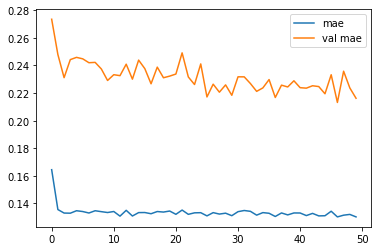

In [72]:
mae2_a = history2_a.history['mae']
val_mae2_a = history2_a.history['val_mae']
epoch2_a = range(len(mae2_a))

plt.plot(epoch2_a, mae2_a, label='mae')
plt.plot(epoch2_a, val_mae2_a, label='val mae')
plt.legend()
plt.show()

In [73]:
prediction2_a = forecast_predict(model2_a, test_cabaimerah_, time_size=win_size, batch_size=5)

data_result2_a = prediction2_a[(len(x_train))-win_size:-1, -1 ]
data_result2_a = scal_range.inverse_transform(data_result2_a.reshape(-1, 1))
data_result2_a = data_result2_a.reshape(-1)
mae2_a = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a)
mape2_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a)
mse2_a = tf.keras.metrics.mean_squared_error(x_test, data_result2_a)

rmse2_a = math.sqrt(mse2_a.numpy())
print(mae2_a.numpy(), mape2_a.numpy(), rmse2_a)

data_new_cabaimerah2_a = pd.DataFrame()
data_new_cabaimerah2_a['actual'] = x_test
data_new_cabaimerah2_a['prediction'] = data_result2_a
data_new_cabaimerah2_a.to_csv('cabaimerah_model3_adam-type1.csv')

data_new_cabaimerah2_a

131/131 [==============================] - 3s 17ms/step
6621.638 15.848936 7896.802644108563


,actual,prediction
0,40450,37893.750000
1,39500,38147.007812
2,37200,38533.839844
3,36850,38310.648438
4,35850,38022.691406
...,...,...
229,40450,42912.261719
230,53850,42807.566406
231,51150,43107.078125
232,40750,42879.632812


#### Type 2

In [74]:
history2_a1 = model2_a.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 17s 23ms/step - loss: 0.0293 - mae: 0.1323 - mape: 294502.0312 - val_loss: 0.0667 - val_mae: 0.2171 - val_mape: 49.1473
Epoch 2/50
718/718 [==============================] - 16s 23ms/step - loss: 0.0283 - mae: 0.1308 - mape: 294954.5938 - val_loss: 0.0606 - val_mae: 0.2094 - val_mape: 50.6238
Epoch 3/50
718/718 [==============================] - 17s 23ms/step - loss: 0.0280 - mae: 0.1306 - mape: 331084.4375 - val_loss: 0.0635 - val_mae: 0.2130 - val_mape: 49.9650
Epoch 4/50
718/718 [==============================] - 17s 23ms/step - loss: 0.0276 - mae: 0.1287 - mape: 363482.8750 - val_loss: 0.0616 - val_mae: 0.2111 - val_mape: 50.7426
Epoch 5/50
718/718 [==============================] - 16s 23ms/step - loss: 0.0274 - mae: 0.1277 - mape: 372212.0000 - val_loss: 0.0594 - val_mae: 0.2088 - val_mape: 51.7245
Epoch 6/50
718/718 [==============================] - 16s 22ms/step - loss: 0.0272 - mae: 0.1272 - mape: 311619.0938 - val_loss: 0

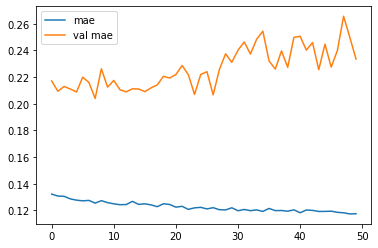

In [75]:
mae2_a1 = history2_a1.history['mae']
val_mae2_a1 = history2_a1.history['val_mae']
epoch2_a1 = range(len(mae2_a1))

plt.plot(epoch2_a1, mae2_a1, label='mae')
plt.plot(epoch2_a1, val_mae2_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 5ms/step
6487.3726 16.205606 7601.9387000948645


,actual,prediction
0,40450,40423.218750
1,39500,40421.445312
2,37200,41733.695312
3,36850,41562.644531
4,35850,40892.832031
...,...,...
229,40450,47261.273438
230,53850,45821.160156
231,51150,46867.769531
232,40750,46375.292969


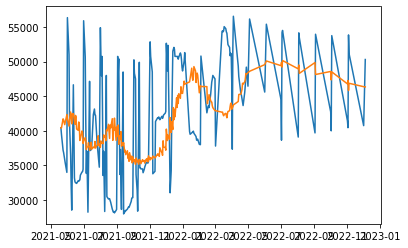

In [76]:
prediction2_a1 = forecast_predict(model2_a, test_cabaimerah_, time_size=win_size1, batch_size=5)

data_result2_a1 = prediction2_a1[(len(x_train))-win_size1:-1, -1 ]
data_result2_a1 = scal_range.inverse_transform(data_result2_a1.reshape(-1, 1))
data_result2_a1 = data_result2_a1.reshape(-1)
mae2_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a1)
mape2_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a1)
mse2_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a1)

rmse2_a1 = math.sqrt(mse2_a1.numpy())
print(mae2_a1.numpy(), mape2_a1.numpy(), rmse2_a1)

data_new_cabaimerah2_a1 = pd.DataFrame()
data_new_cabaimerah2_a1['actual'] = x_test
data_new_cabaimerah2_a1['prediction'] = data_result2_a1
data_new_cabaimerah2_a1.to_csv('cabaimerah_model3_adam-type2.csv')

plt.plot(y_test, data_new_cabaimerah2_a1.actual)
plt.plot(y_test, data_new_cabaimerah2_a1.prediction)
data_new_cabaimerah2_a1

#### Type 3

In [77]:
history2_a2 = model2_a.fit(train_step2, epochs= 50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 7s 85ms/step - loss: 0.0322 - mae: 0.1419 - mape: 547126.2500 - val_loss: 0.0815 - val_mae: 0.2408 - val_mape: 49.1294
Epoch 2/50
84/84 [==============================] - 7s 86ms/step - loss: 0.0314 - mae: 0.1397 - mape: 493452.9062 - val_loss: 0.0801 - val_mae: 0.2382 - val_mape: 49.0131
Epoch 3/50
84/84 [==============================] - 7s 85ms/step - loss: 0.0317 - mae: 0.1401 - mape: 508272.6562 - val_loss: 0.0793 - val_mae: 0.2368 - val_mape: 48.9582
Epoch 4/50
84/84 [==============================] - 7s 85ms/step - loss: 0.0307 - mae: 0.1389 - mape: 523551.0938 - val_loss: 0.0826 - val_mae: 0.2423 - val_mape: 49.1806
Epoch 5/50
84/84 [==============================] - 7s 84ms/step - loss: 0.0313 - mae: 0.1389 - mape: 512251.4062 - val_loss: 0.0805 - val_mae: 0.2391 - val_mape: 49.0525
Epoch 6/50
84/84 [==============================] - 7s 84ms/step - loss: 0.0308 - mae: 0.1364 - mape: 475878.4688 - val_loss: 0.0845 - val_mae: 0

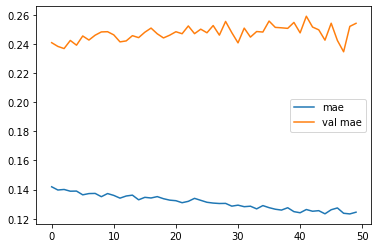

In [78]:
mae2_a2 = history2_a2.history['mae']
val_mae2_a2 = history2_a2.history['val_mae']
epoch2_a2 = range(len(mae2_a2))

plt.plot(epoch2_a2, mae2_a2, label='mae')
plt.plot(epoch2_a2, val_mae2_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 2s 9ms/step
7849.5566 18.78876 9290.790278550045


,actual,prediction
0,40450,45184.496094
1,39500,43747.839844
2,37200,44854.187500
3,36850,43251.187500
4,35850,46310.144531
...,...,...
229,40450,41030.718750
230,53850,40963.351562
231,51150,41107.992188
232,40750,40898.277344


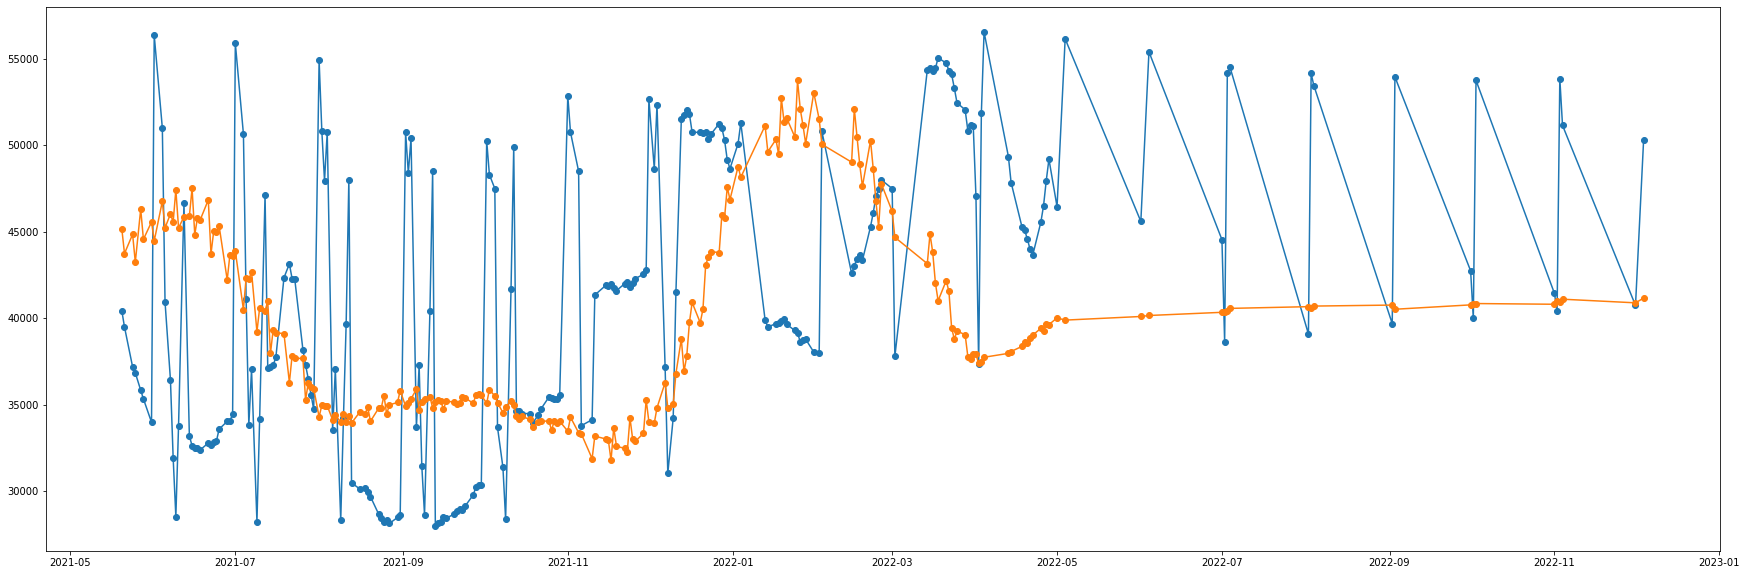

In [79]:
prediction2_a2 = forecast_predict(model2_a, test_cabaimerah_, time_size=win_size2, batch_size=5)

data_result2_a2 = prediction2_a2[(len(x_train))-win_size2:-1, -1 ]
data_result2_a2 = scal_range.inverse_transform(data_result2_a2.reshape(-1, 1))
data_result2_a2 = data_result2_a2.reshape(-1)
mae2_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a2)
mape2_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a2)
mse2_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a2)

rmse2_a2 = math.sqrt(mse2_a2.numpy())
print(mae2_a2.numpy(), mape2_a2.numpy(), rmse2_a2)

data_new_cabaimerah2_a2 = pd.DataFrame()
data_new_cabaimerah2_a2['actual'] = x_test
data_new_cabaimerah2_a2['prediction'] = data_result2_a2
data_new_cabaimerah2_a2.to_csv('cabaimerah_model3_adam_type3.csv')

plt.figure(figsize=(30, 10))
plt.plot(y_test,data_new_cabaimerah2_a2.actual, '-o')
plt.plot(y_test,data_new_cabaimerah2_a2.prediction, '-o')
data_new_cabaimerah2_a2